In [1]:
import ufl
from ufl import dx, ds, grad, TrialFunction, TestFunction, FacetNormal, lhs, rhs,SpatialCoordinate,exp

import dolfinx
from dolfinx import mesh, fem, io
from dolfinx.fem import Constant, FunctionSpace,Function, dirichletbc,locate_dofs_geometrical,form
from dolfinx.fem.petsc import LinearProblem

from mpi4py import MPI
from petsc4py.PETSc import ScalarType
import numpy as np
import matplotlib.pyplot as plt


class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


def all_boundary_dofs(domain, space):
    """Find all doundary dofs on space

    Args:
        domain (mesh): Mesh of points
        space (FunctionSpace): FunctionSpace

    Returns:
        list: Boundary dofs
    """
    domain.topology.create_connectivity(
        domain.topology.dim - 1,
        domain.topology.dim,
        )
    boundary_facets = mesh.exterior_facet_indices(domain.topology)
    boundary_dofs = fem.locate_dofs_topological(
        space,
        domain.topology.dim - 1,
        boundary_facets,
        )
    return boundary_dofs


dot = Infix(ufl.inner)


def errors_L(uS, uEx):
    """Compute error norm on boundary

    Args:
        uS (Function): Numeric solution
        uEx (Function): Exact or model solution

    Returns:
        List: L1 and L2 norms
    """
    domain = uS.function_space.mesh

    V_err = FunctionSpace(
        domain,
        ('CG', uS.function_space.element.space_dimension),
        )
    uEx = express(V_err, uEx)
    L1_scalar = fem.assemble_scalar(form((uS-uEx) * dx))
    L2_scalar = fem.assemble_scalar(form((uS - uEx)**2 * dx))

    L1_err = np.abs(domain.comm.allreduce(L1_scalar, op=MPI.SUM))
    L2_err = np.sqrt(domain.comm.allreduce(L2_scalar, op=MPI.SUM))
    return (L1_err, L2_err)


def express(space, func):
    """Express function on new space

    Args:
        space (FunctionSpace): New space
        function (): Any function

    Returns:
        fem.Function: Function
    """

    if not hasattr(func, 'ufl_domain'):
        func2 = Function(space)
        func2.interpolate(func)
    else:
        func2 = func

    expr = fem.Expression(func2, space.element.interpolation_points())
    func2 = Function(space)
    func2.interpolate(expr)
    return func2


def line_collision(domain, line_cord):
    """Generate points and cells of colliding domain and line

    Args:
        domain (mesh): Domain
        line_cord (array): 3D line contervertor of coordinates 

    Returns:
        Tuple: Collision points and collision cells
    """
    bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)

    cells_on_line = []
    points_on_line = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, line_cord.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(
        domain, cell_candidates, line_cord.T
        )
    for i, point in enumerate(line_cord.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_line.append(point)
            cells_on_line.append(colliding_cells.links(i)[0])

    points_on_line = np.array(points_on_line, dtype=np.float64)

    return (points_on_line, cells_on_line)


def graph2D(fig, lists):
    """Create graph

    Args:
        fig (figure): Figure
        lists (u , axe, title): List of arguments
    """

    def data_construct(dofs, x_array):
        data = np.column_stack((dofs[:, 0:2], x_array))
        x_data = data[:, 0]
        y_data = data[:, 1]
        z_data = data[:, 2]
        return [x_data, y_data, z_data]

    for list in lists:
        u, axe, title = list
        dofs = u.function_space.tabulate_dof_coordinates()

        levels = np.linspace(u.x.array.min(), u.x.array.max(), 10)
        axe.set_title(title)
        plot = axe.tricontourf(
            *data_construct(dofs, u.x.array),
            levels=levels,
            )
        axe.set_aspect(1)
        fig.colorbar(plot, ax=axe)
    return


In [9]:
N = 10
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N)
V = FunctionSpace(domain, ('CG', 1))
x, y = SpatialCoordinate(V)

euEx = 1 + x**2 + 2 * y**2
uEx = express(V, euEx)
uD1 = express(V, 1 + 2 * y**2)
uD2 = express(V, 2 + 2 * y**2)
uNe = express(V, -4 * y)
f = Constant(V, ScalarType(-6))
u, v = TrialFunction(V), TestFunction(V)

In [10]:
def bound1(x):
    return np.isclose(x[0], 0)


bound1_dofs = locate_dofs_geometrical(V, bound1)
bcs1 = dirichletbc(uD1, bound1_dofs)


def bound2(x):
    return np.isclose(x[0], 1)


bound2_dofs = locate_dofs_geometrical(V, bound2)
bcs2 = dirichletbc(uD2, bound2_dofs)

bcs = [bcs1, bcs2]

F = (grad(u)|dot|grad(v)) * dx - (f*v) * dx + (uNe*v) * ds

In [11]:
problem = LinearProblem(
    lhs(F),
    rhs(F),
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly", "pc_type": "lu"
        },
    )
uS = problem.solve()

In [12]:
error = errors_L(uS=uS,uEx=euEx)
print(f'L1 error = {error[0]:.2e} \nL2 error = {error[1]:.2e}')

L1 error = 1.67e+00 
L2 error = 1.70e+00


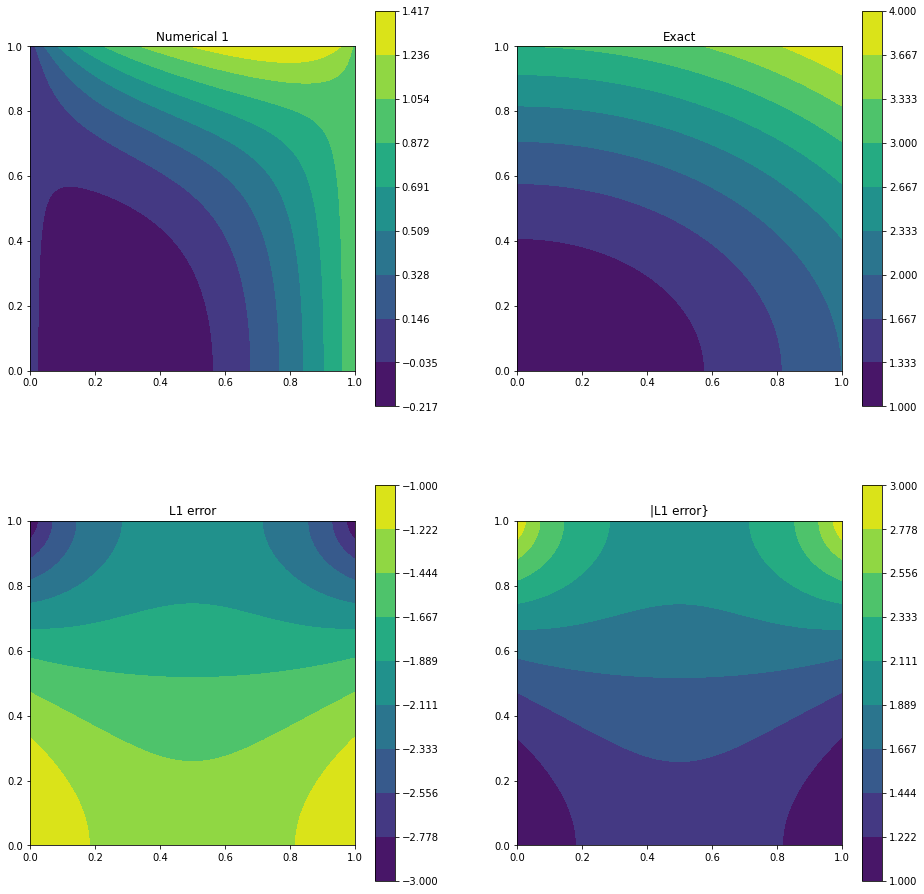

In [13]:
u_dif = express(V, (uS - uEx))
u_dif_mod = express(V, abs(uS - uEx))

fig, ((ax_S, ax_Ex), (ax_dif, ax_dif2)) = plt.subplots(2, 2)
fig.set_size_inches(16, 16)

lis = [
    [uS, ax_S, 'Numerical 1'],
    [uEx, ax_Ex, 'Exact'],
    [u_dif, ax_dif, 'L1 error'],
    [u_dif_mod, ax_dif2, '|L1 error}'],
    ]

graph2D(fig=fig, lists=lis)

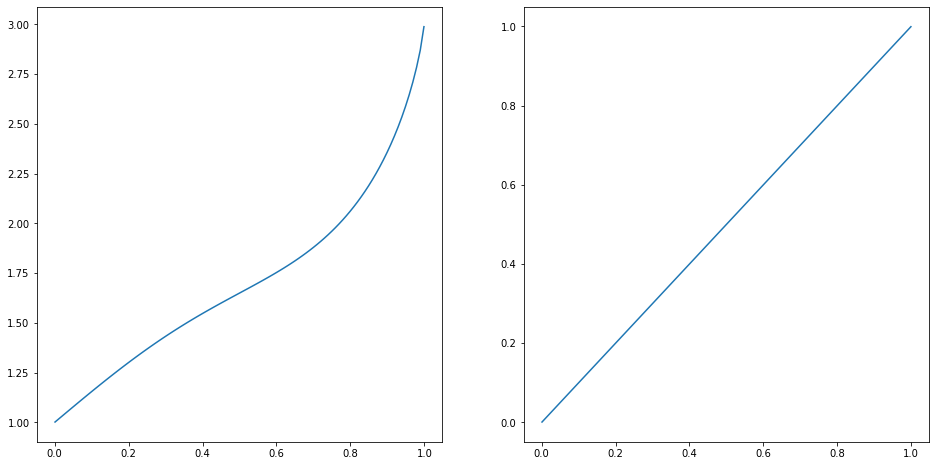

In [14]:
tol = 0.001
line_N = N
x_line = np.linspace(0 + tol, 1 - tol, line_N + 1)
y_line = x_line
line = np.zeros((3, line_N + 1))
line[0] = x_line
line[1] = y_line
line_col = line_collision(domain=domain, line_cord=line)

fig, (ax, ax_direct) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)

ax_direct.plot(x_line, y_line)

uS_slice = uS.eval(*line_col)
uEx_slice = uEx.eval(*line_col)
u_dif_mod_slice = u_dif_mod.eval(*line_col)

# ax.plot(x_line, uS_slice.flatten())
ax.plot(x_line, u_dif_mod_slice.flatten())


In [15]:
with io.XDMFFile(
    domain.comm,
    'My_files/MyPoisson.xdmf',
    'w',
) as file:
    file.write_mesh(domain)
    uS.name = 'Numeric'
    file.write_function (uS)
    uEx.name = 'Exact'
    file.write_function(uEx)